# Proyecto final IDI2

### Importando librerías

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

### Importando imágenes 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "archive\data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

#### Visualicemos una muestra del lote de imágenes

Este código es una forma útil de visualizar un lote de imágenes y etiquetas en un conjunto de datos de clasificación de imágenes. Esto puede ser útil para verificar si las imágenes se cargan correctamente y si las etiquetas coinciden con las imágenes.

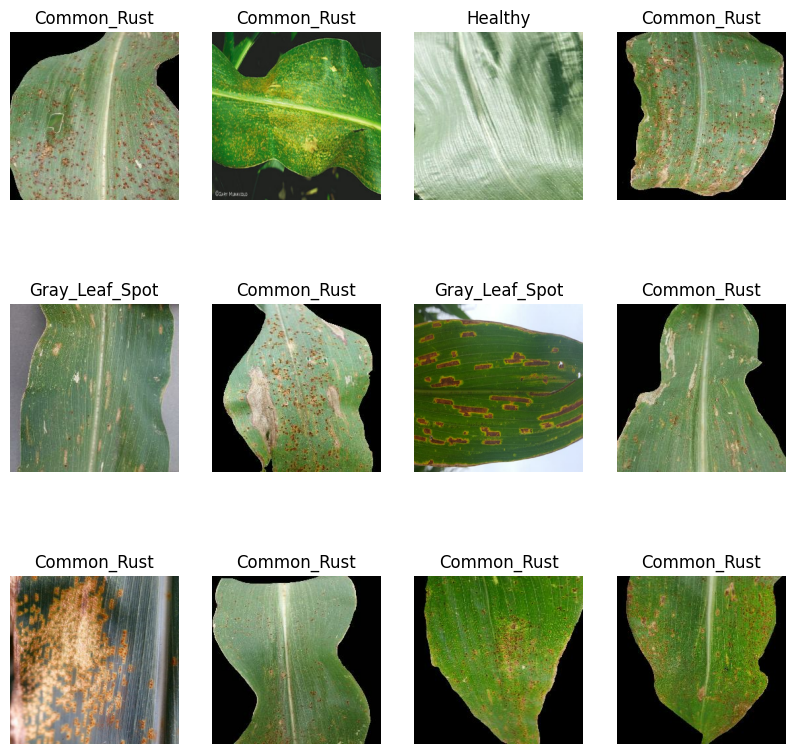

In [5]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Preprocesamiento de los datos

In [6]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [8]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 104

Length of Validation Dataset is 13

Length of Testing Dataset is 14


In [9]:
# optimizaciones adicionales a los conjuntos de datos de entrenamiento, validación y prueba creados por la función get_dataset()
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

* cache(): Almacena en caché los elementos del conjunto de datos en memoria o en disco, lo que permite una recuperación más rápida de los datos durante el entrenamiento.
* shuffle(1000): Baraja aleatoriamente los elementos del conjunto de datos, utilizando un tamaño de búfer de 1000 elementos. La aleatorización puede mejorar la generalización del modelo y evitar que el modelo se sobreajuste a patrones específicos del conjunto de datos.
* prefetch(buffer_size=tf.data.AUTOTUNE): Prefetch los elementos del conjunto de datos para el procesamiento posterior. El tamaño del búfer se establece en tf.data.AUTOTUNE, lo que permite que TensorFlow determine el tamaño óptimo del búfer de acuerdo con la memoria disponible en el sistema y otras consideraciones.

#### Preprocesador de imágenes

In [10]:
# Usa dos capas secuenciales para cambiar el tamaño de las imágenes y ajustar sus valores de píxel a un rango entre 0 y 1.
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

Estas capas de preprocesamiento son útiles para normalizar las imágenes de entrada antes de que se alimenten a la CNN para su entrenamiento. Al normalizar las imágenes, los valores de píxel se ajustan a un rango común, lo que ayuda a la CNN a aprender patrones y características importantes de manera más efectiva.

#### Aumentación de datos

La aumentación de datos se refiere a la aplicación de transformaciones aleatorias a las imágenes para crear nuevas variaciones de las mismas. Esto puede mejorar la capacidad de generalización de la CNN y reducir el sobreajuste.

In [11]:
data_augmentation = tf.keras.Sequential([
    # Las imágenes puedan voltearse horizontalmente y verticalmente de forma aleatoria
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    # Las imágenes pueden rotarse aleatoriamente en un ángulo de hasta 0.2 radianes
    layers.experimental.preprocessing.RandomRotation(0.2), 
])

### Modelo CNN

In [12]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3) #espera un lote de imágenes de tamaño 256x256 con 3 canales de color (RGB). 
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # 5 capas convolucionales
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)), # cada capa convolucional va seguida de una de agrupación
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), # aplana los mapas de características en un vector de una dimensión
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'), #tiene 4 neuronas, y produce una distribución de probabilidad sobre las clases.
    
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

RMSProp es un optimizador popular utilizado en el aprendizaje profundo para actualizar los pesos de la red neuronal durante el entrenamiento. Es una variante del algoritmo de descenso de gradiente estocástico (SGD) que adapta la tasa de aprendizaje de cada peso en función de su historial de gradientes.

In [14]:
model.compile(
optimizer='RMSProp',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

La función de pérdida elegida es la entropía cruzada categórica escasa, que es adecuada para problemas de clasificación multiclase donde cada ejemplo puede tener solo una etiqueta verdadera. La opción **from_logits=False** indica que el modelo produce una distribución de probabilidad directamente, en lugar de salidas lineales (logits) que deben transformarse con una función de activación softmax

### Ajustando el modelo a los datos

Este método entrena el modelo en los datos de entrenamiento durante un número fijo de épocas y devuelve un objeto History que contiene información sobre la evolución de la función de pérdida y las métricas de entrenamiento y validación a lo largo del tiempo.

In [15]:
history = model.fit(
train_ds,
epochs=40,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/40
104/104 [==============================] - 212s 2s/step - loss: 1.0005 - accuracy: 0.5716 - val_loss: 0.7073 - val_accuracy: 0.7284
Epoch 2/40
104/104 [==============================] - 187s 2s/step - loss: 0.5922 - accuracy: 0.7837 - val_loss: 0.4493 - val_accuracy: 0.8438
Epoch 3/40
104/104 [==============================] - 192s 2s/step - loss: 0.4721 - accuracy: 0.8282 - val_loss: 0.4062 - val_accuracy: 0.8462
Epoch 4/40
104/104 [==============================] - 195s 2s/step - loss: 0.4256 - accuracy: 0.8366 - val_loss: 0.3986 - val_accuracy: 0.8486
Epoch 5/40
104/104 [==============================] - 173s 2s/step - loss: 0.3931 - accuracy: 0.8436 - val_loss: 0.3201 - val_accuracy: 0.8702
Epoch 6/40
104/104 [==============================] - 146s 1s/step - loss: 0.3545 - accuracy: 0.8565 - val_loss: 0.3431 - val_accuracy: 0.8726
Epoch 7/40
104/104 [==============================] - 147s 1s/step - loss: 0.3395 - accuracy: 0.8715 - val_loss: 0.3322 - val_accuracy: 0.8413

Ejecutamos el modelo en el conjunto de datos de prueba

In [16]:
scores = model.evaluate(test_ds) # devuelve la pérdida y la precisión en los datos de prueba

14/14 [==============================] - 14s 283ms/step - loss: 0.1492 - accuracy: 0.9554


In [17]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 104}

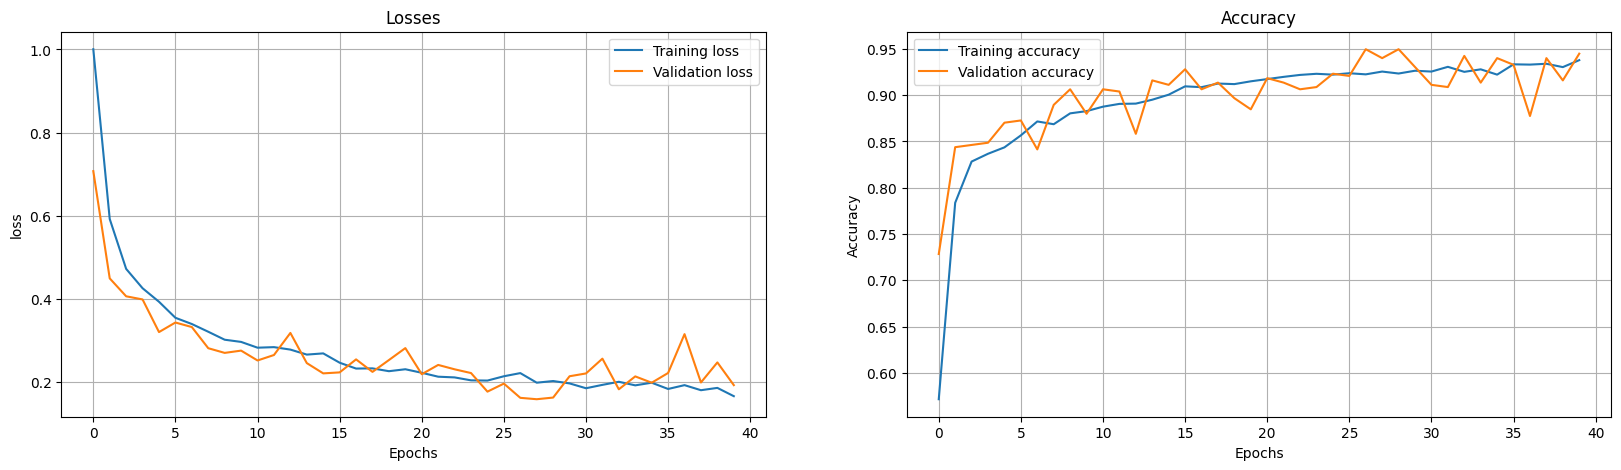

In [18]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))
# Graficando las curvas de la función de pérdida y la precisión por separado.
plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

### Predicción/diagnóstico 

First Image to Predict :

Actual label: Blight
1/1 [==============================] - 0s 398ms/step

Predicted label: Blight


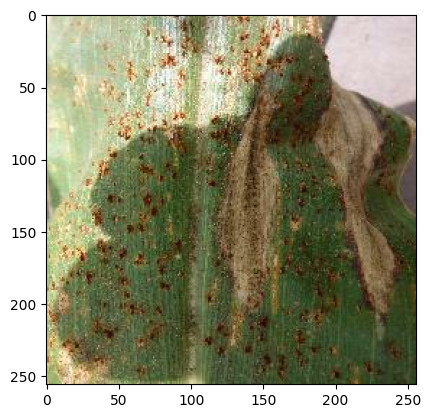

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    #se selecciona la primera imagen y su etiqueta
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) # es un vector de probabilidades para cada clase
    # la etiqueta se determina tomando el índice de la clase con la probabilidad más alta utilizando la función argmax
    print("\nPredicted label:" ,class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


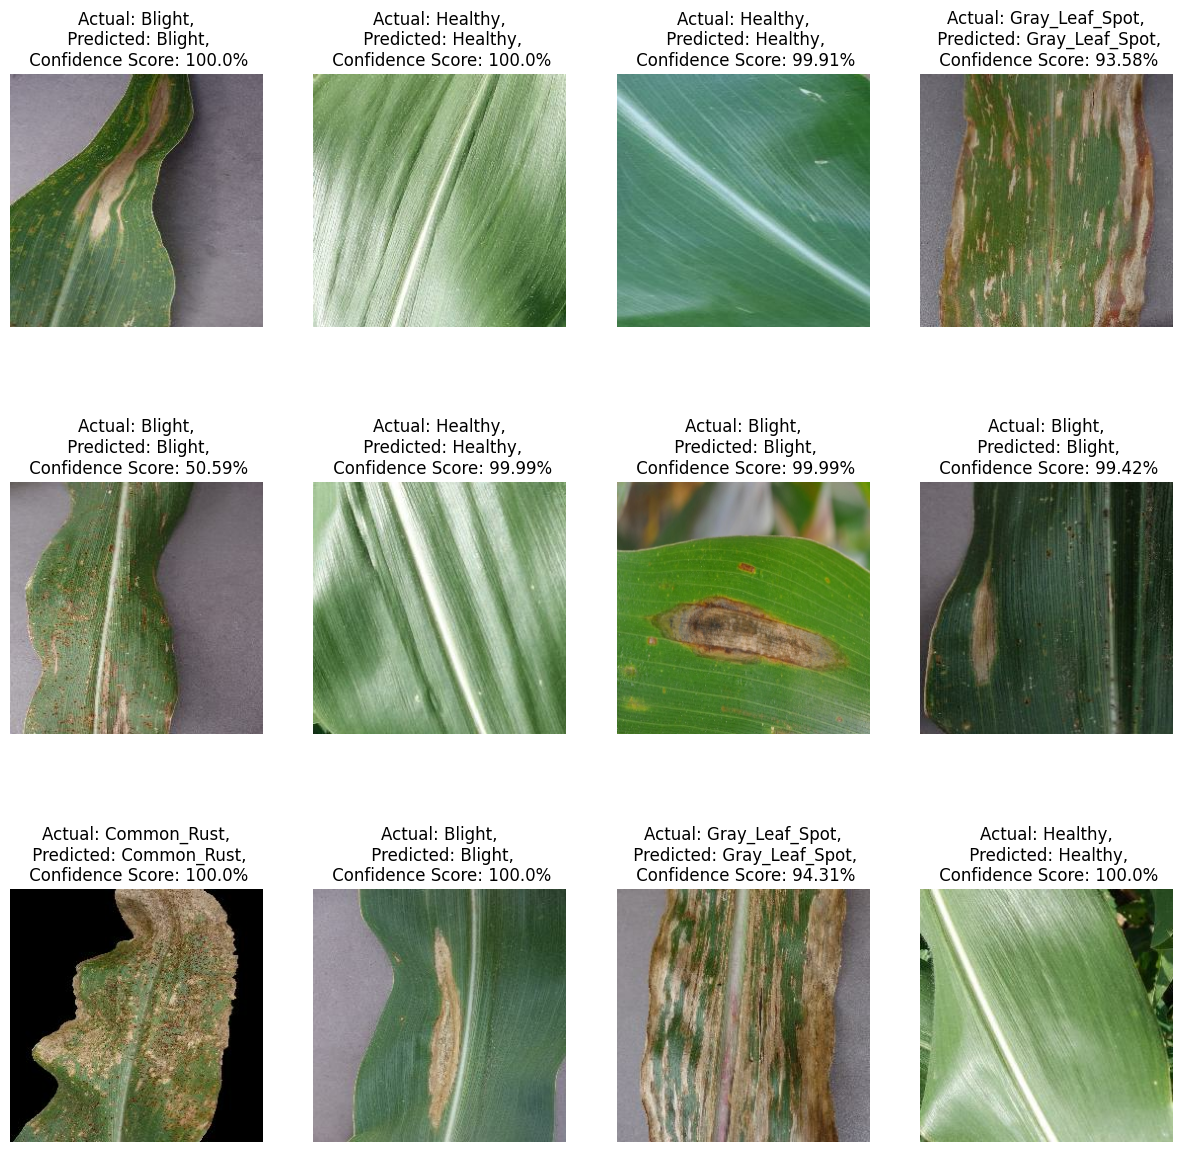

In [21]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [22]:
model.save('Proyecto final/model_1')

INFO:tensorflow:Assets written to: Proyecto final/model_1\assets


INFO:tensorflow:Assets written to: Proyecto final/model_1\assets
